In [1]:
!pip install scikit-learn
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: python-debian 0.1.43ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of python-debian or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
Defaulting to user installation because normal site-packages is not writeable
DEPRECATION: distro-info 1.1build1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement 

In [2]:
import pickle
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
import pickle
import torch

pickle_file_path = "eval.pkl"

records = []
try:
    with open(pickle_file_path, 'rb') as f:
        while True:
            # Load the tensor onto CPU and then move to 'cuda:0'
            record = pickle.load(f)
            records.append(record)
except EOFError:
    # EOFError is raised when pickle reaches the end of the file
    pass


KeyboardInterrupt: 

In [3]:
len(records)

300

In [20]:
import pandas as pd
recordsdf = pd.DataFrame(records)
filtered_df = recordsdf[recordsdf['SSIM'] > 0.79]
filtered_df


In [22]:

df_sorted = filtered_df.sort_values(by='PSNR', ascending=False)
df_grouped = df_sorted.groupby(['Query', 'Prompt'], as_index=False).first()
used_prompts = set()
used_queries = set()

unique_rows = []
for index, row in df_grouped.iterrows():
    if row['Prompt'] not in used_prompts and row['Query'] not in used_queries:
        used_prompts.add(row['Prompt'])
        used_queries.add(row['Query'])
        unique_rows.append(row)

df_unique = pd.DataFrame(unique_rows)

df_unique = df_unique.head(15)

df_unique

,Query,Prompt,PSNR,SSIM,ReprMatrix
0,1.png,122.png,19.970528,0.818289,"[[[tensor([[-1.2904, 0.2752, -0.7728, ..., ..."
21,111.png,144.png,14.657072,0.840205,"[[[tensor([[-1.3080, 0.5208, -0.5400, ..., ..."
42,146.png,149.png,21.799216,0.858897,"[[[tensor([[-1.2085, 0.4692, -0.5968, ..., ..."
63,22.png,167.png,27.157605,0.877858,"[[[tensor([[-1.3438, 0.5241, -0.4625, ..., ..."
84,23.png,174.png,25.438628,0.839610,"[[[tensor([[-1.2842e+00, 8.9424e-01, -5.1145e..."
105,547.png,184.png,16.324148,0.830782,"[[[tensor([[-1.3676, 0.6121, -0.5874, ..., ..."
126,55.png,207.png,18.976131,0.857283,"[[[tensor([[-1.1667, 0.8655, -0.4038, ..., ..."
147,669.png,222.png,27.248700,0.887552,"[[[tensor([[-1.2596, 0.4903, -0.4212, ..., ..."
168,748.png,253.png,27.566008,0.871064,"[[[tensor([[-1.2468, 0.2364, -0.4192, ..., ..."
189,79.png,261.png,28.065620,0.902332,"[[[tensor([[-1.1048, 0.2296, -0.6235, ..., ..."


In [36]:
def plot_metric(title, data_matrix, colorbar_label, num_layers=4):
    """
    Create a heatmap plot of the data matrix with appropriate labels and title.
    
    Parameters:
    title (str): The title of the plot.
    data_matrix (numpy.ndarray): The 2D data matrix to plot.
    colorbar_label (str): The label for the colorbar.
    num_layers (int): The number of concatenated layers in the data_matrix.
    layer_height (int): The original height of each layer before concatenation.
    """
    # Calculate the total width of the concatenated layers
    width = data_matrix.shape[-1]
    layer_height = data_matrix.shape[-2]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    im = plt.imshow(data_matrix, cmap='viridis', aspect='equal')
    plt.colorbar(im, label=colorbar_label)
    plt.title(title, fontsize=16)
    
    # Adjust the x-axis to reflect the layer and token position
    # We assume that each layer has the same width
    layer_width = width // num_layers
    x_ticks = np.arange(0, width, layer_width)
    x_labels = [f'Layer {i+1}' for i in range(num_layers)]
    
    plt.xlabel('Token Position and Layer', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation='vertical', fontsize=12)
    
    # Adjust the y-axis to reflect the token position in height
    y_ticks = np.arange(0, layer_height, 5)
    y_labels = [str(i) for i in y_ticks]
    
    plt.ylabel('Token Position (Height)', fontsize=14)
    plt.yticks(y_ticks, y_labels, fontsize=12)
    
    plt.tight_layout()
    plt.show()

def plot_histogram(title, data_matrix, xlabel, bins=1000, log=False):
    
    plt.hist(data_matrix.flatten(), bins=bins, log=log)  # Set log=True for logarithmically spaced bins
    if log:
        plt.xscale('log')  # Set x-axis to be logarithmic
    plt.xlabel(xlabel)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.show()

def reshape_layers(matrix, squeeze=True, dim=-1):
    matrix = matrix.squeeze(1) if squeeze else matrix
    reshaped_matrix = torch.cat(tuple(matrix), dim=dim)
    reshaped_matrix_np = reshaped_matrix.numpy()
    return reshaped_matrix_np

def plot_pca_rgb(pca_rgb_matrix, title, num_layers=4):
    """
    Plot the RGB visualization of PCA coefficients for a given layer.

    Parameters:
    pca_rgb_matrix (numpy.ndarray): An array of shape (num_layers, height, width, 3) containing PCA coefficients.
    layer_idx (int): The index of the layer to visualize.
    """
    # Normalize the PCA coefficients to [0, 1] for valid RGB mapping
    pca_rgb_matrix = (pca_rgb_matrix - pca_rgb_matrix.min()) / (pca_rgb_matrix.max() - pca_rgb_matrix.min())
    
    # Calculate the total width of the concatenated layers
    width = pca_rgb_matrix.shape[-2]
    layer_height = pca_rgb_matrix.shape[-3]
    
    # Create the plot
    plt.figure(figsize=(12, 6))
    im = plt.imshow(pca_rgb_matrix, aspect='equal')
    plt.title(title, fontsize=16)
    
    # Adjust the x-axis to reflect the layer and token position
    # We assume that each layer has the same width
    layer_width = width // num_layers
    x_ticks = np.arange(0, width, layer_width)
    x_labels = [f'Layer {i+1}' for i in range(num_layers)]
    
    plt.xlabel('Token Position and Layer', fontsize=14)
    plt.xticks(x_ticks, x_labels, rotation='vertical', fontsize=12)
    
    # Adjust the y-axis to reflect the token position in height
    y_ticks = np.arange(0, layer_height, 5)
    y_labels = [str(i) for i in y_ticks]
    
    plt.ylabel('Token Position (Height)', fontsize=14)
    plt.yticks(y_ticks, y_labels, fontsize=12)
    
    plt.tight_layout()
    plt.show()


In [37]:
def calculate_norm_mse(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Compute mean squared error
    mse = torch.mean((stacked_matrices - mean_matrix) ** 2, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mse = torch.norm(mse, dim=-1)

    return norm_mse

def calculate_avg_mse(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Compute mean squared error
    mse = torch.mean((stacked_matrices - mean_matrix) ** 2, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mse = torch.mean(mse, dim=-1)

    return norm_mse

def calculate_norm_mean(stacked_matrices):
    # Compute the mean across the examples (0th dimension)
    mean_matrix = torch.mean(stacked_matrices, dim=0)

    # Norm along the feature axis (last dimension)
    norm_mean = torch.norm(mean_matrix, dim=-1)

    return norm_mean

def calculate_mean_norm(stacked_matrices):
    # Compute the norm of each feature vector
    norm_matrix = torch.norm(stacked_matrices, dim=-1)

    # Mean along the examples dimension
    mean_of_norms = torch.mean(norm_matrix, dim=0)

    return mean_of_norms

def perform_pca_on_features(stacked_matrices, n_components=3):
    """
    Perform PCA on all features across all examples and layers for each token position.
    The result is then reshaped to have RGB values for each token position.
    
    Parameters:
    repr_matrices (list): A list of records, where each record is a dictionary containing 'ReprMatrix'.
    n_components (int): The number of principal components to compute, default is 3 for RGB.
    
    Returns:
    numpy.ndarray: An array of shape (num_layers, height, width, n_components) containing PCA coefficients.
    """    
    # Reshape to form a matrix of shape [num_data_points, num_features]
    # where num_data_points = num_examples * num_layers * height * width
    num_examples, num_layers, _, height, width, num_features = stacked_matrices.shape
    feature_matrix = stacked_matrices.view(-1, num_features).cpu().numpy()

    # Perform PCA
    pca = PCA(n_components=n_components)
    pca_result = pca.fit_transform(feature_matrix)

    # Reshape the result back to (num_layers, height, width, n_components)
    pca_result = pca_result.reshape((num_examples, num_layers, height, width, n_components))
    
    # We'll take the mean across examples to represent the average principal component coefficients
    pca_result = pca_result.mean(axis=0)
    
    return pca_result


In [30]:
records = torch.stack([a.detach() for a in df_unique['ReprMatrix']])

In [43]:
len(records)

10

In [34]:
import torch
import gc
# Release CUDA memory
torch.cuda.empty_cache()

# Perform garbage collection
gc.collect()

50

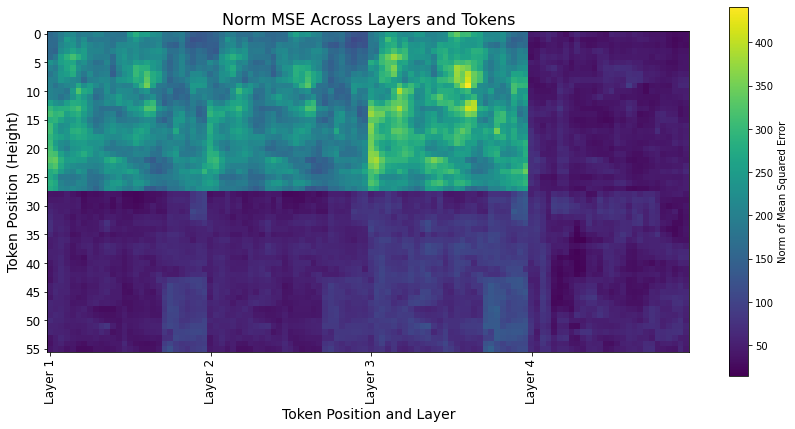

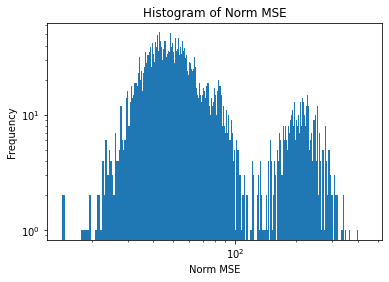

In [38]:
norm_mse_matrix = reshape_layers(calculate_norm_mse(records).cpu())
plot_metric('Norm MSE Across Layers and Tokens', norm_mse_matrix, 'Norm of Mean Squared Error')
plot_histogram("Histogram of Norm MSE", norm_mse_matrix, "Norm MSE", log=True)

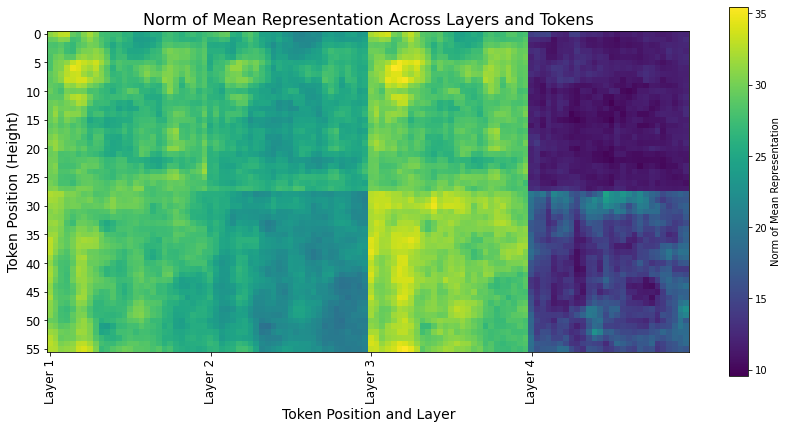

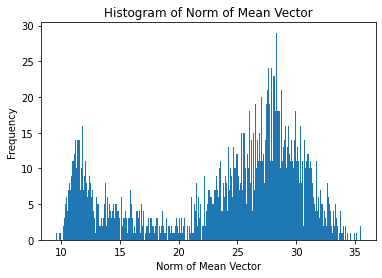

In [39]:
norm_mean_matrix = reshape_layers(calculate_norm_mean(records).cpu())
plot_metric('Norm of Mean Representation Across Layers and Tokens', norm_mean_matrix, 'Norm of Mean Representation')
plot_histogram("Histogram of Norm of Mean Vector", norm_mean_matrix, "Norm of Mean Vector")

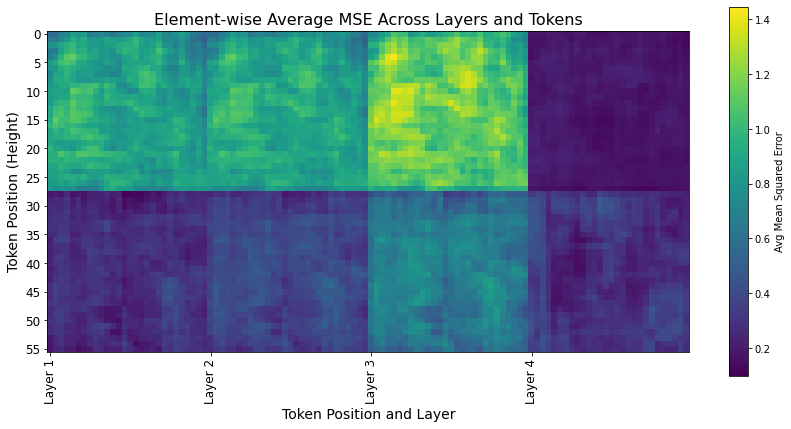

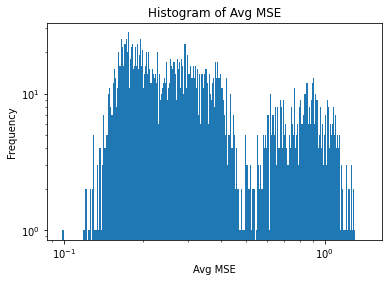

In [40]:
avg_mse_matrix = reshape_layers(calculate_avg_mse(records).cpu())
plot_metric('Element-wise Average MSE Across Layers and Tokens', avg_mse_matrix, 'Avg Mean Squared Error')
plot_histogram("Histogram of Avg MSE", avg_mse_matrix, "Avg MSE", log=True)

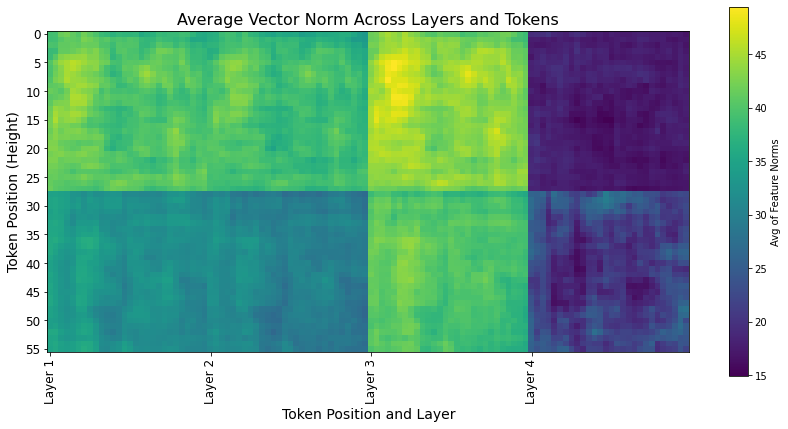

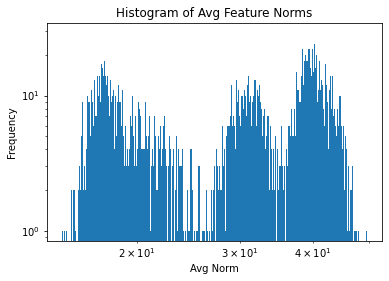

In [41]:
mean_norm_matrix = reshape_layers(calculate_mean_norm(records).cpu())
plot_metric('Average Vector Norm Across Layers and Tokens', mean_norm_matrix, 'Avg of Feature Norms')
plot_histogram("Histogram of Avg Feature Norms", mean_norm_matrix, "Avg Norm", log=True)

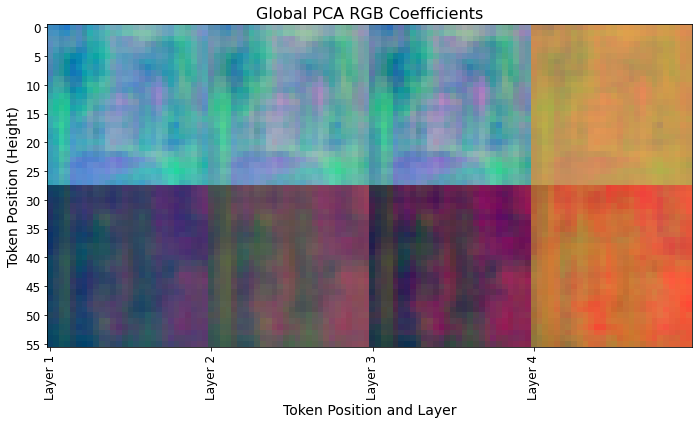

In [42]:
# Calculate PCA coefficients
pca_rgb_matrix = perform_pca_on_features(records)
reshaped_pca_matrix = reshape_layers(torch.from_numpy(pca_rgb_matrix), squeeze=False, dim=-2)

# Plot PCA RGB coefficients for the first layer as an example
plot_pca_rgb(reshaped_pca_matrix, "Global PCA RGB Coefficients")